In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# Project Steps

Steps we’ve covered so far:
1. Camera calibration
2. Distortion correction
3. Color/gradient threshold
4. Perspective transform

After doing these steps, you’ll be given two additional steps for the project:
5. Detect lane lines
6. Determine the lane curvature

# Processing Each Image

- in the project at the end of this module, the first thing you'll do is to compute the camera calibration matrix and distortion coefficients
- you only need to compute these once, and then you'll apply them to undistort each new frame
- next, you'll apply thresholds to create a binary image and then apply a perspective transform

## Thresholding

- you'll want to try out various combinations of color and gradient thresholds to generate a binary image where the lane lines are clearly visible
- there's more than one way to achieve a good result, but for example, the output you're going for should look something like this: 

<img src="resources/thresholding_example.jpg" style="width: 80%;"/>

## Perspective Transform

- next, you want to identify four source points for your perspective transform
- in this case, you can assume the road is a flat plane
    - this isn't strictly true, but it can serve as an approximation for this project
- you would like to pick four points in a trapezoidal shape (similar to region masking) that would represent a rectangle when looking down on the road from above
- the easiest way to do this is to investigate an image where the lane lines are straight, and find four points lying along the lines that, after perspective transform, make the lines look straight and vertical from a bird's eye view perspective
- here's an example of the result you are going for with straight lane lines:

<img src="resources/warped-straight-lines.jpg"/>

- those same four source points will now work to transform any image (again, under the assumption that the road is flat and the camera perspective hasn't changed)
- when applying the transform to new images, the test of whether or not you got the transform correct, is that the lane lines should appear parallel in the warped images, whether they are straight or curved

- here's an example of applying a perspective transform to your thresholded binary image, using the same source and destination points as above, showing that the curved lines are (more or less) parallel in the transformed image:

<img src="resources/warped-curved-lines.jpg"/>

# Finding the Lines: Histogram Peaks

- you now have a thresholded warped image and you're ready to map out the lane lines!
- there are many ways you could go about this, but here's one example of how you might do it

## Line Finding Method: Peaks in a Histogram

- after applying calibration, thresholding, and a perspective transform to a road image, you should have a binary image where the lane lines stand out clearly
- however, you still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line
- plotting a histogram of where the binary activations occur across the image is one potential solution for this

In [2]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

<IPython.core.display.Javascript object>

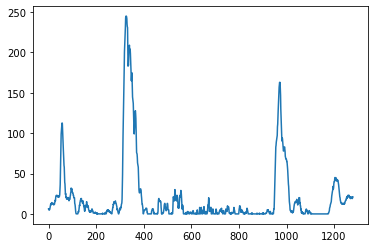

<IPython.core.display.Javascript object>

In [3]:
# Load our image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
img = mpimg.imread("resources/warped-example.jpg") / 255


def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0] // 2 :, :]

    # Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    # Take a histogram along all the columns in the lower half of the image
    histogram = np.sum(bottom_half, axis=0)

    return histogram


# Create histogram of image binary activations
histogram = hist(img)

# Visualize the resulting histogram
plt.plot(histogram)

## Sliding Window

- with this histogram we are adding up the pixel values along each column in the image
- in our thresholded binary image, pixels are either 0 or 1, so the two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines
- we can use that as a starting point for where to search for the lines
- from that point, we can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame

# Finding the Lines: Sliding Window
## Implement Sliding Windows and Fit a Polynomial

<img src="resources/implement_sliding_windows_and_fit_a_polynomial.png" style="width: 80%;"/>

- we can use the two highest peaks from our histogram as a starting point for determining where the lane lines are, and then use sliding windows moving upward in the image (further along the road) to determine where the lane lines go

In [4]:
# Load our image
binary_warped = mpimg.imread("resources/warped-example.jpg")


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2 :, :], axis=0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS - related to our sliding windows
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0] // nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # 1. Loop through each window in nwindows

    # 2. Find the boundaries of our current window.
    #    This is based on a combination of the current window's starting point
    #    (leftx_current and rightx_current), as well as the margin you set in the hyperparameters.

    # 3. Use cv2.rectangle to draw these window boundaries onto our visualization image out_img.
    #    This is required for the quiz, but you can skip this step in practice if you don't need
    #    to visualize where the windows are.

    # 4. Now that we know the boundaries of our window, find out which activated pixels from
    #    nonzeroy and nonzerox above actually fall into the window.

    # 5. Append these to our lists left_lane_inds and right_lane_inds.

    # 6. If the number of pixels you found in Step 4 are greater than your hyperparameter minpix,
    #    re-center our window (i.e. leftx_current or rightx_current) based on the mean position of these pixels.

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(
            out_img,
            (win_xleft_low, win_y_low),
            (win_xleft_high, win_y_high),
            (0, 255, 0),
            2,
        )
        cv2.rectangle(
            out_img,
            (win_xright_low, win_y_low),
            (win_xright_high, win_y_high),
            (0, 255, 0),
            2,
        )

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = (
            (nonzeroy >= win_y_low)
            & (nonzeroy < win_y_high)
            & (nonzerox >= win_xleft_low)
            & (nonzerox < win_xleft_high)
        ).nonzero()[0]
        good_right_inds = (
            (nonzeroy >= win_y_low)
            & (nonzeroy < win_y_high)
            & (nonzerox >= win_xright_low)
            & (nonzerox < win_xright_high)
        ).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

<IPython.core.display.Javascript object>

- `numpy.sum` https://numpy.org/doc/1.18/reference/generated/numpy.sum.html
- `numpy.dstack` https://numpy.org/doc/1.18/reference/generated/numpy.dstack.html
- `numpy.nonzero` https://docs.scipy.org/doc/numpy/reference/generated/numpy.nonzero.html
- `numpy.argmax` https://numpy.org/doc/1.18/reference/generated/numpy.argmax.html

In [5]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    # Take note of how we fit the lines above
    # while normally you calculate a y-value for a given x
    # here we do the opposite because we expect our lane lines to be (mostly) vertically-oriented
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print("The function failed to fit a line!")
        left_fitx = 1 * ploty ** 2 + 1 * ploty
        right_fitx = 1 * ploty ** 2 + 1 * ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color="yellow")
    plt.plot(right_fitx, ploty, color="yellow")

    return out_img

<IPython.core.display.Javascript object>

- `numpy.linspace` https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html

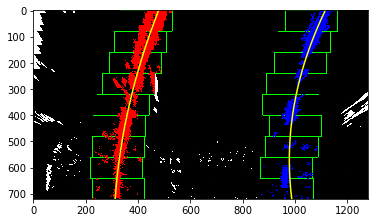

<IPython.core.display.Javascript object>

In [6]:
out_img = fit_polynomial(binary_warped)

plt.imshow(out_img)

# Finding the Lines: Search from Prior
## Skip the sliding windows step once you've found the lines

<img src="resources/skip_the_sliding_windows_step.png" style="width: 80%;"/>

- using the full algorithm from before and starting fresh on every frame may seem inefficient, as the lane lines don't necessarily move a lot from frame to frame.
- in the next frame of video you don't need to do a blind search again, but instead you can just search in a margin around the previous lane line position, like in the above image
- the green shaded area shows where we searched for the lines this time
    - so, once you know where the lines are in one frame of video, you can do a highly targeted search for them in the next frame
- this is equivalent to using a customized region of interest for each frame of video, and should help you track the lanes through sharp curves and tricky conditions
- if you lose track of the lines, go back to your sliding windows search or other method to rediscover them

- in the previous quiz, we used `left_lane_inds` and `right_lane_inds` to hold the pixel values contained within the boundaries of a given sliding window
- this time, we'll take the polynomial functions we fit before (`left_fit` and `right_fit`), along with a hyperparameter `margin`, to determine which activated pixels fall into the green shaded areas from the above image
- note that this `margin` can be a different value than the one originally used for your sliding windows!
- to implement, you'll want to grab only those pixels with x-values that are +/- your `margin` from your polynomial lines

In [7]:
# Load our image - this should be a new frame since last time!
binary_warped = mpimg.imread("resources/warped-example.jpg")

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([2.13935315e-04, -3.77507980e-01, 4.76902175e02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01, 1.11806170e03])


def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    return left_fitx, right_fitx, ploty

<IPython.core.display.Javascript object>

In [8]:
def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = (
        nonzerox
        > (
            left_fit[0] * (nonzeroy ** 2)
            + left_fit[1] * nonzeroy
            + left_fit[2]
            - margin
        )
    ) & (
        nonzerox
        < (
            left_fit[0] * (nonzeroy ** 2)
            + left_fit[1] * nonzeroy
            + left_fit[2]
            + margin
        )
    )
    right_lane_inds = (
        nonzerox
        > (
            right_fit[0] * (nonzeroy ** 2)
            + right_fit[1] * nonzeroy
            + right_fit[2]
            - margin
        )
    ) & (
        nonzerox
        < (
            right_fit[0] * (nonzeroy ** 2)
            + right_fit[1] * nonzeroy
            + right_fit[2]
            + margin
        )
    )

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(
        binary_warped.shape, leftx, lefty, rightx, righty
    )

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array(
        [np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))]
    )
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array(
        [np.transpose(np.vstack([right_fitx - margin, ploty]))]
    )
    right_line_window2 = np.array(
        [np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))]
    )
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color="yellow")
    plt.plot(right_fitx, ploty, color="yellow")
    ## End visualization steps ##

    return result

<IPython.core.display.Javascript object>

- `numpy.vstack` https://docs.scipy.org/doc/numpy/reference/generated/numpy.vstack.html
- `numpy.hstack` https://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html
- `numpy.flipud` https://docs.scipy.org/doc/numpy/reference/generated/numpy.flipud.html

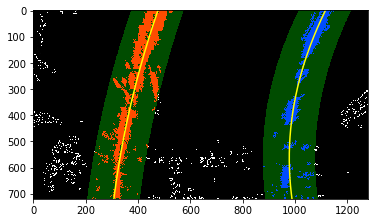

<IPython.core.display.Javascript object>

In [9]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_warped)

# View your output
plt.imshow(result)

## Fitting on Large Curves

- one thing to consider in our current implementation of sliding window search is what happens when we arrive at the left or right edge of an image, such as when there is a large curve on the road ahead
- if `minpix` is not achieved (i.e. the curve ran off the image), the starting position of our next window doesn't change, so it is just positioned directly above the previous window
- this will repeat for however many windows are left in `nwindows`, stacking the sliding windows vertically against the side of the image, and likely leading to an imperfect polynomial fit

# Measuring Curvature

<img src="resources/color-fit-lines.jpg" style="width: 80%;"/>

- in the last exercise, we located the lane line pixels, used their x and y pixel positions to fit a second order polynomial curve: $f(y)=Ay^2+By+C$
- we're fitting for $f(y)$, rather than $f(x)$, because the lane lines in the warped image are near vertical and may have the same $x$ value for more than one $y$ value. 

## Radius of Curvature

https://www.intmath.com/applications-differentiation/8-radius-curvature.php
- the radius of curvature  at any point $x$ of the function $x=f(y)$ is given as follows:
<center>$R_{curve} = \dfrac{\left[1+\left(\dfrac{dx}{dy}\right)^2\right]^{3/2}}{\left|\dfrac{d^2x}{dy^2}\right|}$</center>
<br/>
- in the case of the second order polynomial above, the first and second derivatives are:
<center>$f'(y) = \dfrac{dx}{dy} = 2Ay + B$</center>
<center>$f''(y) = \dfrac{d^2x}{dy^2} = 2A$</center>
- so, our equation for radius of curvature becomes:
<center>$R_{curve} = \dfrac{\left(1+(2Ay + B)^2\right)^{3/2}}{\left|2A\right|}$</center>

- the $y$ values of your image increase from top to bottom, so if, for example, you wanted to measure the radius of curvature closest to your vehicle, you could evaluate the formula above at the $y$ value corresponding to the bottom of your image, or in Python, at `yvalue = image.shape[0]`.

## Implementing the Calculation
### Generate some fake data first

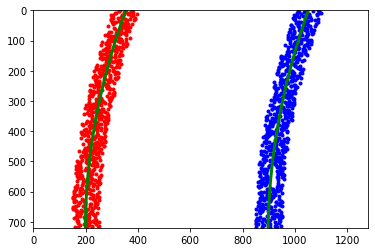

<IPython.core.display.Javascript object>

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)  # to cover same y-range as image
quadratic_coeff = 3e-4  # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array(
    [200 + (y ** 2) * quadratic_coeff + np.random.randint(-50, high=51) for y in ploty]
)
rightx = np.array(
    [900 + (y ** 2) * quadratic_coeff + np.random.randint(-50, high=51) for y in ploty]
)

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, "o", color="red", markersize=mark_size)
plt.plot(rightx, ploty, "o", color="blue", markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color="green", linewidth=3)
plt.plot(right_fitx, ploty, color="green", linewidth=3)
plt.gca().invert_yaxis()  # to visualize as we do the images

### Implementing the calculation itself

In [18]:
import numpy as np


def generate_data():
    """
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    """
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)  # to cover same y-range as image
    quadratic_coeff = 3e-4  # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array(
        [
            200 + (y ** 2) * quadratic_coeff + np.random.randint(-50, high=51)
            for y in ploty
        ]
    )
    rightx = np.array(
        [
            900 + (y ** 2) * quadratic_coeff + np.random.randint(-50, high=51)
            for y in ploty
        ]
    )

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    right_fit = np.polyfit(ploty, rightx, 2)

    return ploty, left_fit, right_fit

<IPython.core.display.Javascript object>

- `numpy.random.seed` https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.seed.html

In [12]:
def measure_curvature_pixels():
    """
    Calculates the curvature of polynomial functions in pixels.
    """
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit, right_fit = generate_data()

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Calculation of R_curve (radius of curvature)
    left_curverad = (
        (1 + (2 * left_fit[0] * y_eval + left_fit[1]) ** 2) ** 1.5
    ) / np.absolute(2 * left_fit[0])
    right_curverad = (
        (1 + (2 * right_fit[0] * y_eval + right_fit[1]) ** 2) ** 1.5
    ) / np.absolute(2 * right_fit[0])

    return left_curverad, right_curverad

<IPython.core.display.Javascript object>

In [13]:
# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels()

print(left_curverad, right_curverad)
# Should see values of 1625.06 and 1976.30 here, if using
# the default `generate_data` function with given seed number

1625.0601831657204 1976.2967307714334


<IPython.core.display.Javascript object>

## From Pixels to Real-World

- we've calculated the radius of curvature based on pixel values, so the radius we are reporting is in pixel space, which is not the same as real world space
- so we actually need to repeat this calculation after converting our *x* and *y* values to real world space.
- this involves measuring how long and wide the section of lane is that we're projecting in our warped image
    - we could do this in detail by measuring out the physical lane in the field of view of the camera, but for this project, you can assume that if you're projecting a section of lane similar to the images above, the lane is about 30 meters long and 3.7 meters wide
    - or, if you prefer to derive a conversion from pixel space to world space in your own images, compare your images with U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters, and the dashed lane lines are 10 feet or 3 meters long each
- let's say that our camera image has 720 relevant pixels in the y-dimension (remember, our image is perspective-transformed!), and we'll say roughly 700 relevant pixels in the x-dimension (our example of fake generated data above used from 200 pixels on the left to 900 on the right, or 700)
    - therefore, to convert from pixels to real-world meter measurements, we can use:

In [14]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30 / 720  # meters per pixel in y dimension
xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

<IPython.core.display.Javascript object>

In [15]:
import numpy as np


def generate_data(ym_per_pix, xm_per_pix):
    """
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    """
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)  # to cover same y-range as image
    quadratic_coeff = 3e-4  # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array(
        [
            200 + (y ** 2) * quadratic_coeff + np.random.randint(-50, high=51)
            for y in ploty
        ]
    )
    rightx = np.array(
        [
            900 + (y ** 2) * quadratic_coeff + np.random.randint(-50, high=51)
            for y in ploty
        ]
    )

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)

    return ploty, left_fit_cr, right_fit_cr

<IPython.core.display.Javascript object>

In [16]:
def measure_curvature_real():
    """
    Calculates the curvature of polynomial functions in meters.
    """
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Calculation of R_curve (radius of curvature)
    left_curverad = (
        (1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5
    ) / np.absolute(2 * left_fit_cr[0])
    right_curverad = (
        (1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5
    ) / np.absolute(2 * right_fit_cr[0])

    return left_curverad, right_curverad

<IPython.core.display.Javascript object>

In [17]:
# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real()

print(left_curverad, "m", right_curverad, "m")
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number

533.7525889210938 m 648.157485143441 m


<IPython.core.display.Javascript object>

- an insightful student has suggested an alternative approach which may scale more efficiently
- that is, once the parabola coefficients are obtained, in pixels, convert them into meters
- for example, if the parabola is `x = a*(y**2) + b*y + c` and `mx` and `my` are the scale for the *x* and *y* axis, respectively (in meters/pixel) then the scaled parabola is `x = mx/(my**2)*a*(y**2) + (mx/my)*b*y + c`

- check out the U.S. government specifications for highway curvature to see how your numbers compare
http://onlinemanuals.txdot.gov/txdotmanuals/rdw/horizontal_alignment.htm#BGBHGEGC
- there's no need to worry about absolute accuracy in this case, but your results should be "order of magnitude" correct

## Bonus Round: Computer Vision

### Lane Finding with Semantic Segmentation

**Fully Convolutional Networks for Semantic Segmentation** by E. Shelhamer, J. Long and T. Darrell
https://arxiv.org/abs/1605.06211

***Abstract:*** *Convolutional networks are powerful visual models that yield hierarchies of features. We show that convolutional networks by themselves, trained end-to-end, pixels-to-pixels, improve on the previous best result in semantic segmentation. Our key insight is to build "fully convolutional" networks that take input of arbitrary size and produce correspondingly-sized output with efficient inference and learning. We define and detail the space of fully convolutional networks, explain their application to spatially dense prediction tasks, and draw connections to prior models. We adapt contemporary classification networks (AlexNet, the VGG net, and GoogLeNet) into fully convolutional networks and transfer their learned representations by fine-tuning to the segmentation task. We then define a skip architecture that combines semantic information from a deep, coarse layer with appearance information from a shallow, fine layer to produce accurate and detailed segmentations. [...]*

You can use the KITTI road dataset with the above technique for a model that can detect open space on the road.
http://www.cvlibs.net/datasets/kitti/eval_road.php

Lane Detection with Deep Learning (Part 1) and (Part 2) by M. Virgo
- https://towardsdatascience.com/lane-detection-with-deep-learning-part-1-9e096f3320b7
- https://towardsdatascience.com/lane-detection-with-deep-learning-part-2-3ba559b5c5af

***Summary:*** *Udacity SDC student (and now Udacian!) investigates using a deep learning approach to lane detection in order to improve upon the Advanced Lane Finding project, eventually building a model with a fully convolutional neural network that detects the road is a wider variety of situations and at faster speed.*

### Other Lane Finding Techniques

The below paper uses a multi-task model to identify lane and road markings, as well as vanishing point of the road, in order to build a robust model.

VPGNet: Vanishing Point Guided Network for Lane and Road Marking Detection and Recognition by S. Lee, et. al.
https://arxiv.org/abs/1710.06288

***Abstract:*** *In this paper, we propose a unified end-to-end trainable multi-task network that jointly handles lane and road marking detection and recognition that is guided by a vanishing point under adverse weather conditions. We tackle rainy and low illumination conditions [...] At night, color distortion occurs under limited illumination. As a result, no benchmark dataset exists and only a few developed algorithms work under poor weather conditions. To address this shortcoming, we build up a lane and road marking benchmark which consists of about 20,000 images with 17 lane and road marking classes under four different scenarios: no rain, rain, heavy rain, and night. We train and evaluate several versions of the proposed multi-task network and validate the importance of each task. The resulting approach, VPGNet, can detect and classify lanes and road markings, and predict a vanishing point with a single forward pass. Experimental results show that our approach achieves high accuracy and robustness under various conditions in real-time (20 fps). [...]*

### Vehicle Detection

The below paper builds a model to both detect vehicles as well as estimate their dimensions along the road.

Learning to Map Vehicles into Bird's Eye View by A. Palazzi, et. al.
https://arxiv.org/abs/1706.08442

***Abstract:*** *Awareness of the road scene is an essential component for both autonomous vehicles and Advances Driver Assistance Systems and is gaining importance both for the academia and car companies. This paper presents a way to learn a semantic-aware transformation which maps detections from a dashboard camera view onto a broader bird's eye occupancy map of the scene. To this end, a huge synthetic dataset featuring 1M couples of frames, taken from both car dashboard and bird's eye view, has been collected and automatically annotated. A deep-network is then trained to warp detections from the first to the second view. We demonstrate the effectiveness of our model against several baselines and observe that is able to generalize on real-world data despite having been trained solely on synthetic ones.*